In [1]:
import tensorflow as tf
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

In [2]:
def loadData():
    data = io.loadmat("face_landmark.mat")
    images = data["images"]
    landmarks = data["landmarks"]
    print("im_shape:", images.shape)
    print("landmarks_shape:", landmarks.shape)

    return images, landmarks

In [3]:
images, landmarks = loadData()

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


# Visualize Data

In [4]:
def visualize_data(images, landmarks, num_images):
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(num_images):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        for (x, y) in landmarks[i].reshape(-1, 2):
            # Plot keypoints/landmarks on the image
            ax.scatter(x, y, marker='o', s=10, color='r')

    plt.show()

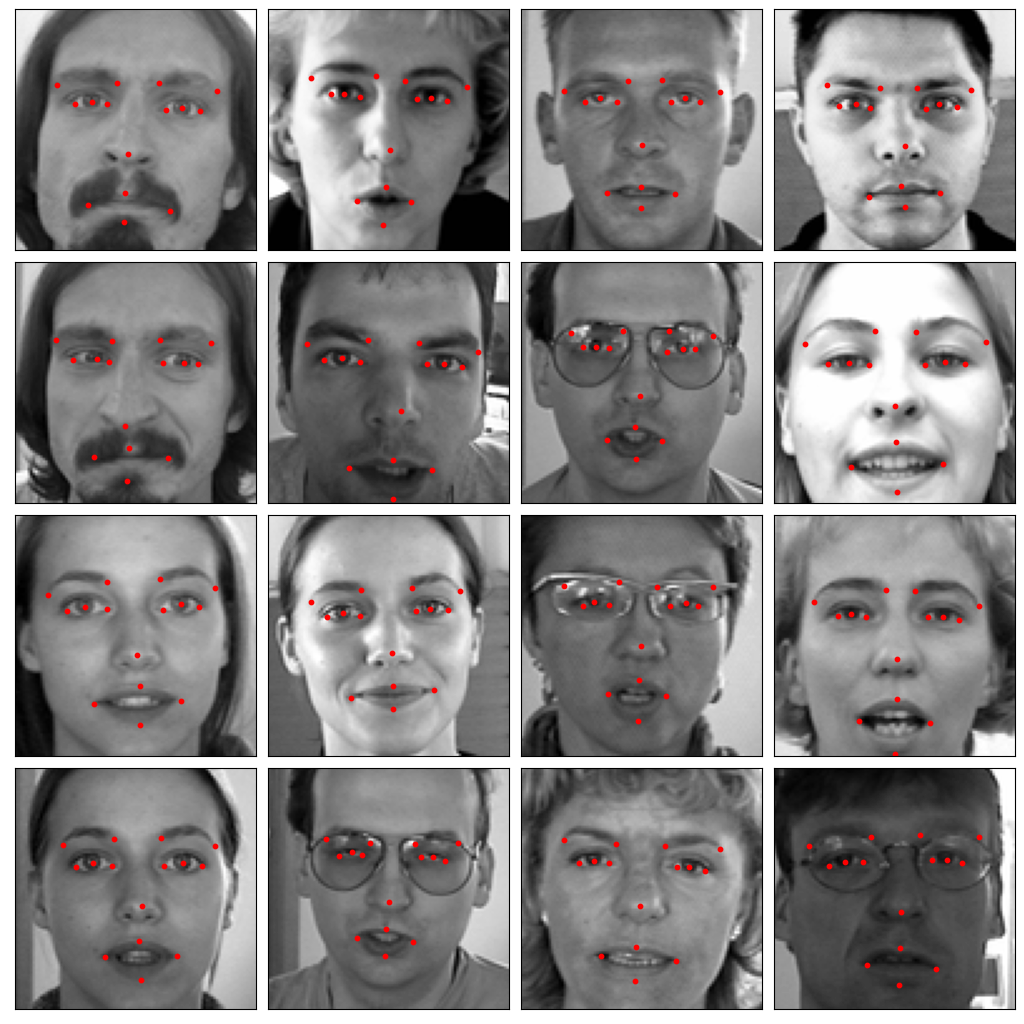

In [5]:
visualize_data(images, landmarks, num_images=16)

# Preprocessing

### split

In [6]:
def split_data(data, size):
    np.random.seed(2023)
    
    idx = np.random.permutation(size)

    train_size = int(size * 0.6)
    val_size = int(size * 0.2)
    test_size = int(size * 0.2)

    train_ds = data[idx[: train_size]]
    val_ds = data[idx[train_size: train_size + val_size]]
    test_ds = data[idx[size - test_size:]]

    return train_ds, val_ds, test_ds

In [7]:
train_img, val_img, test_img = split_data(images, images.shape[0])

In [8]:
train_lmrk, val_lmrk, test_lmrk = split_data(landmarks, landmarks.shape[0])

### Reshape

In [9]:
print(train_img.shape)
print(train_lmrk.shape)

(1284, 96, 96)
(1284, 15, 2)


In [10]:
print(val_img.shape)
print(val_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [11]:
print(test_img.shape)
print(test_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [12]:
train_lmrk = train_lmrk.reshape((1284, -1))
val_lmrk = val_lmrk.reshape((428, -1))
test_lmrk = test_lmrk.reshape((428, -1))

In [13]:
print(train_lmrk.shape)
print(val_lmrk.shape)
print(test_lmrk.shape)

(1284, 30)
(428, 30)
(428, 30)


# Model
* Output은 15개의 얼굴 랜드마크에 해당하는 x, y 좌표이므로 총 30개의 출력 유닛이 필요

In [14]:
# Define the input shape
input_layer = tf.keras.Input(shape=(96, 96, 1))

# Define the convolution and pooling layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the tensor output for the Fully Connected layer
x = tf.keras.layers.Flatten()(x)

# Define the fully connected layer
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Define the output layer (30 units for 15 landmarks x and y coordinates)
output_layer = tf.keras.layers.Dense(30)(x)

# Create the model
model = tf.keras.Model(input_layer, output_layer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496 

## Predict

In [15]:
@tf.function
def predict(x):
    return model(x, training=False)

# Optimization

In [16]:
@tf.function
def optimize(x,y_true,loss_function):
    with tf.GradientTape() as tape:
        y_pred = predict(x)
        loss = loss_function(y_pred, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Loss
* 실제 레이블(y_true)와 모델의 예측 결과(y)를 입력

In [18]:
@tf.function
def l1_loss(y_pred, y_true):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

@tf.function
def l2_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def cosine_loss(y_pred, y_true):
    # Normalize each vector
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    # Compute the dot product (cosine similarity)
    dot_product = tf.reduce_sum(y_true_normalized * y_pred_normalized, axis=-1)
    # Subtract the dot product from 1 to get the loss
    return 1 - tf.reduce_mean(dot_product)


In [19]:
def combine_l2_cosine_loss(y_pred, y_true, lamda=0.1):
    return l2_loss(y_pred, y_true) + lamda*cosine_loss(y_pred, y_true)

# Train & Evaluation

In [20]:
""" start training """
loss_function = combine_l2_cosine_loss

max_epochs = 1000
batch_size = 32


loss_history = []
val_loss_best = np.inf
train_size = int(images.shape[0] * 0.6)

#Early stopping hyperparameter
patience = 50  # number of epochs to wait before stopping if there is no improvement
wait = 0  # counter for epochs without improvement


for epoch in range(max_epochs):
    # get a minibatch
    idx = np.random.permutation(train_size)
    batch_idx = idx[:batch_size]

    # optimize
    train_loss = optimize(train_img[batch_idx], train_lmrk[batch_idx], loss_function)
    train_loss = train_loss.numpy()

    # evaluate on val_set
    y = predict(val_img)
    val_loss = loss_function(y, val_lmrk).numpy()

    # Early stopping check
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
        
    print('Epoch:', epoch, '. Training Loss:', train_loss, ' Validation Loss:', val_loss, ' Best Validation Loss:', val_loss_best)
    loss_history.append([train_loss, val_loss])

Epoch: 0 . Training Loss: 2950.881  Validation Loss: 2256.7683  Best Validation Loss: 2256.7683
Epoch: 1 . Training Loss: 2254.0442  Validation Loss: 1819.9572  Best Validation Loss: 1819.9572
Epoch: 2 . Training Loss: 1816.405  Validation Loss: 1403.6625  Best Validation Loss: 1403.6625
Epoch: 3 . Training Loss: 1374.3755  Validation Loss: 1146.25  Best Validation Loss: 1146.25
Epoch: 4 . Training Loss: 1128.2449  Validation Loss: 998.094  Best Validation Loss: 998.094
Epoch: 5 . Training Loss: 1077.9922  Validation Loss: 848.21594  Best Validation Loss: 848.21594
Epoch: 6 . Training Loss: 843.05316  Validation Loss: 746.08167  Best Validation Loss: 746.08167
Epoch: 7 . Training Loss: 716.36694  Validation Loss: 661.3617  Best Validation Loss: 661.3617
Epoch: 8 . Training Loss: 665.32654  Validation Loss: 586.3455  Best Validation Loss: 586.3455
Epoch: 9 . Training Loss: 565.39374  Validation Loss: 524.06464  Best Validation Loss: 524.06464
Epoch: 10 . Training Loss: 480.9243  Validat

Epoch: 84 . Training Loss: 110.03865  Validation Loss: 114.21174  Best Validation Loss: 108.05659
Epoch: 85 . Training Loss: 99.49213  Validation Loss: 108.88555  Best Validation Loss: 108.05659
Epoch: 86 . Training Loss: 79.17071  Validation Loss: 123.112206  Best Validation Loss: 108.05659
Epoch: 87 . Training Loss: 125.399925  Validation Loss: 106.783775  Best Validation Loss: 106.783775
Epoch: 88 . Training Loss: 126.54164  Validation Loss: 130.59666  Best Validation Loss: 106.783775
Epoch: 89 . Training Loss: 115.538216  Validation Loss: 126.83269  Best Validation Loss: 106.783775
Epoch: 90 . Training Loss: 88.34894  Validation Loss: 106.20881  Best Validation Loss: 106.20881
Epoch: 91 . Training Loss: 122.559685  Validation Loss: 156.6038  Best Validation Loss: 106.20881
Epoch: 92 . Training Loss: 161.5652  Validation Loss: 126.20229  Best Validation Loss: 106.20881
Epoch: 93 . Training Loss: 156.25653  Validation Loss: 108.87579  Best Validation Loss: 106.20881
Epoch: 94 . Train

Epoch: 168 . Training Loss: 93.84107  Validation Loss: 94.26095  Best Validation Loss: 93.91979
Epoch: 169 . Training Loss: 111.19103  Validation Loss: 96.108955  Best Validation Loss: 93.91979
Epoch: 170 . Training Loss: 61.303326  Validation Loss: 96.74517  Best Validation Loss: 93.91979
Epoch: 171 . Training Loss: 69.051506  Validation Loss: 95.84231  Best Validation Loss: 93.91979
Epoch: 172 . Training Loss: 79.021034  Validation Loss: 95.127884  Best Validation Loss: 93.91979
Epoch: 173 . Training Loss: 85.20319  Validation Loss: 91.769005  Best Validation Loss: 91.769005
Epoch: 174 . Training Loss: 68.6866  Validation Loss: 92.36153  Best Validation Loss: 91.769005
Epoch: 175 . Training Loss: 59.195774  Validation Loss: 92.31408  Best Validation Loss: 91.769005
Epoch: 176 . Training Loss: 91.93628  Validation Loss: 92.66038  Best Validation Loss: 91.769005
Epoch: 177 . Training Loss: 94.933395  Validation Loss: 96.472755  Best Validation Loss: 91.769005
Epoch: 178 . Training Loss

Epoch: 253 . Training Loss: 52.652794  Validation Loss: 83.96949  Best Validation Loss: 80.14709
Epoch: 254 . Training Loss: 67.98978  Validation Loss: 84.26148  Best Validation Loss: 80.14709
Epoch: 255 . Training Loss: 80.73464  Validation Loss: 84.2714  Best Validation Loss: 80.14709
Epoch: 256 . Training Loss: 81.51379  Validation Loss: 82.75662  Best Validation Loss: 80.14709
Epoch: 257 . Training Loss: 70.54289  Validation Loss: 78.21414  Best Validation Loss: 78.21414
Epoch: 258 . Training Loss: 84.309685  Validation Loss: 85.60392  Best Validation Loss: 78.21414
Epoch: 259 . Training Loss: 87.489136  Validation Loss: 81.285355  Best Validation Loss: 78.21414
Epoch: 260 . Training Loss: 65.896614  Validation Loss: 78.80063  Best Validation Loss: 78.21414
Epoch: 261 . Training Loss: 61.93528  Validation Loss: 87.793045  Best Validation Loss: 78.21414
Epoch: 262 . Training Loss: 73.075096  Validation Loss: 90.58062  Best Validation Loss: 78.21414
Epoch: 263 . Training Loss: 60.955

Epoch: 338 . Training Loss: 49.820213  Validation Loss: 77.02797  Best Validation Loss: 69.88909
Epoch: 339 . Training Loss: 74.29669  Validation Loss: 75.540146  Best Validation Loss: 69.88909
Epoch: 340 . Training Loss: 51.458477  Validation Loss: 71.24114  Best Validation Loss: 69.88909
Epoch: 341 . Training Loss: 63.841583  Validation Loss: 76.62882  Best Validation Loss: 69.88909
Epoch: 342 . Training Loss: 58.980186  Validation Loss: 79.10357  Best Validation Loss: 69.88909
Epoch: 343 . Training Loss: 80.428276  Validation Loss: 74.1999  Best Validation Loss: 69.88909
Epoch: 344 . Training Loss: 62.277626  Validation Loss: 70.498055  Best Validation Loss: 69.88909
Epoch: 345 . Training Loss: 46.873783  Validation Loss: 71.24336  Best Validation Loss: 69.88909
Epoch: 346 . Training Loss: 49.52259  Validation Loss: 75.85552  Best Validation Loss: 69.88909
Epoch: 347 . Training Loss: 45.79584  Validation Loss: 75.38184  Best Validation Loss: 69.88909
Epoch: 348 . Training Loss: 60.3

Epoch: 423 . Training Loss: 45.13732  Validation Loss: 64.240395  Best Validation Loss: 62.1538
Epoch: 424 . Training Loss: 38.99578  Validation Loss: 63.65015  Best Validation Loss: 62.1538
Epoch: 425 . Training Loss: 45.02367  Validation Loss: 61.98451  Best Validation Loss: 61.98451
Epoch: 426 . Training Loss: 55.13559  Validation Loss: 63.198227  Best Validation Loss: 61.98451
Epoch: 427 . Training Loss: 37.20125  Validation Loss: 62.671165  Best Validation Loss: 61.98451
Epoch: 428 . Training Loss: 70.718094  Validation Loss: 62.222836  Best Validation Loss: 61.98451
Epoch: 429 . Training Loss: 45.935898  Validation Loss: 62.669834  Best Validation Loss: 61.98451
Epoch: 430 . Training Loss: 35.943703  Validation Loss: 63.049126  Best Validation Loss: 61.98451
Epoch: 431 . Training Loss: 31.61582  Validation Loss: 64.15297  Best Validation Loss: 61.98451
Epoch: 432 . Training Loss: 27.682661  Validation Loss: 70.96505  Best Validation Loss: 61.98451
Epoch: 433 . Training Loss: 38.0

Epoch: 508 . Training Loss: 41.975945  Validation Loss: 57.531967  Best Validation Loss: 57.531967
Epoch: 509 . Training Loss: 37.242268  Validation Loss: 59.39316  Best Validation Loss: 57.531967
Epoch: 510 . Training Loss: 40.587914  Validation Loss: 59.333694  Best Validation Loss: 57.531967
Epoch: 511 . Training Loss: 30.475609  Validation Loss: 61.255318  Best Validation Loss: 57.531967
Epoch: 512 . Training Loss: 32.581005  Validation Loss: 58.245617  Best Validation Loss: 57.531967
Epoch: 513 . Training Loss: 36.258644  Validation Loss: 63.67247  Best Validation Loss: 57.531967
Epoch: 514 . Training Loss: 29.965582  Validation Loss: 61.87128  Best Validation Loss: 57.531967
Epoch: 515 . Training Loss: 34.14331  Validation Loss: 57.192158  Best Validation Loss: 57.192158
Epoch: 516 . Training Loss: 30.26221  Validation Loss: 64.45391  Best Validation Loss: 57.192158
Epoch: 517 . Training Loss: 38.74917  Validation Loss: 74.031525  Best Validation Loss: 57.192158
Epoch: 518 . Trai

Epoch: 592 . Training Loss: 23.009644  Validation Loss: 54.8101  Best Validation Loss: 53.61335
Epoch: 593 . Training Loss: 27.509207  Validation Loss: 56.18099  Best Validation Loss: 53.61335
Epoch: 594 . Training Loss: 28.217842  Validation Loss: 56.899246  Best Validation Loss: 53.61335
Epoch: 595 . Training Loss: 39.217896  Validation Loss: 54.88181  Best Validation Loss: 53.61335
Epoch: 596 . Training Loss: 29.544697  Validation Loss: 56.1736  Best Validation Loss: 53.61335
Epoch: 597 . Training Loss: 30.969053  Validation Loss: 54.39984  Best Validation Loss: 53.61335
Epoch: 598 . Training Loss: 28.05394  Validation Loss: 59.313007  Best Validation Loss: 53.61335
Epoch: 599 . Training Loss: 33.21368  Validation Loss: 57.45554  Best Validation Loss: 53.61335
Epoch: 600 . Training Loss: 52.525204  Validation Loss: 54.83363  Best Validation Loss: 53.61335
Epoch: 601 . Training Loss: 32.382687  Validation Loss: 55.912296  Best Validation Loss: 53.61335
Epoch: 602 . Training Loss: 36.

Epoch: 676 . Training Loss: 15.72926  Validation Loss: 59.082546  Best Validation Loss: 51.707977
Epoch: 677 . Training Loss: 32.599857  Validation Loss: 60.263493  Best Validation Loss: 51.707977
Epoch: 678 . Training Loss: 28.825449  Validation Loss: 59.67748  Best Validation Loss: 51.707977
Epoch: 679 . Training Loss: 28.172901  Validation Loss: 53.974663  Best Validation Loss: 51.707977
Epoch: 680 . Training Loss: 28.76712  Validation Loss: 53.083954  Best Validation Loss: 51.707977
Epoch: 681 . Training Loss: 36.36058  Validation Loss: 53.74851  Best Validation Loss: 51.707977
Epoch: 682 . Training Loss: 20.615595  Validation Loss: 51.88468  Best Validation Loss: 51.707977
Epoch: 683 . Training Loss: 22.677382  Validation Loss: 57.04022  Best Validation Loss: 51.707977
Epoch: 684 . Training Loss: 31.246801  Validation Loss: 59.2296  Best Validation Loss: 51.707977
Epoch: 685 . Training Loss: 26.573519  Validation Loss: 52.188194  Best Validation Loss: 51.707977
Epoch: 686 . Traini

Epoch: 760 . Training Loss: 33.96506  Validation Loss: 56.28168  Best Validation Loss: 50.26134
Epoch: 761 . Training Loss: 20.906687  Validation Loss: 67.79399  Best Validation Loss: 50.26134
Epoch: 762 . Training Loss: 44.948467  Validation Loss: 60.361805  Best Validation Loss: 50.26134
Epoch: 763 . Training Loss: 30.590252  Validation Loss: 58.02099  Best Validation Loss: 50.26134
Epoch: 764 . Training Loss: 18.45842  Validation Loss: 78.07094  Best Validation Loss: 50.26134
Epoch: 765 . Training Loss: 46.842815  Validation Loss: 56.695114  Best Validation Loss: 50.26134
Epoch: 766 . Training Loss: 30.712547  Validation Loss: 54.23194  Best Validation Loss: 50.26134
Epoch: 767 . Training Loss: 27.808434  Validation Loss: 53.566135  Best Validation Loss: 50.26134
Epoch: 768 . Training Loss: 28.402756  Validation Loss: 51.53475  Best Validation Loss: 50.26134
Epoch: 769 . Training Loss: 27.101849  Validation Loss: 57.045918  Best Validation Loss: 50.26134
Epoch: 770 . Training Loss: 

Epoch: 844 . Training Loss: 16.296055  Validation Loss: 67.256874  Best Validation Loss: 48.217827
Epoch: 845 . Training Loss: 25.10988  Validation Loss: 68.658  Best Validation Loss: 48.217827
Epoch: 846 . Training Loss: 27.70809  Validation Loss: 48.303745  Best Validation Loss: 48.217827
Epoch: 847 . Training Loss: 16.033262  Validation Loss: 56.753685  Best Validation Loss: 48.217827
Epoch: 848 . Training Loss: 24.740702  Validation Loss: 55.338253  Best Validation Loss: 48.217827
Epoch: 849 . Training Loss: 33.48524  Validation Loss: 50.000153  Best Validation Loss: 48.217827
Epoch: 850 . Training Loss: 17.345886  Validation Loss: 61.97374  Best Validation Loss: 48.217827
Epoch: 851 . Training Loss: 27.898676  Validation Loss: 53.155117  Best Validation Loss: 48.217827
Epoch: 852 . Training Loss: 24.41134  Validation Loss: 52.19226  Best Validation Loss: 48.217827
Epoch: 853 . Training Loss: 22.666395  Validation Loss: 58.522144  Best Validation Loss: 48.217827
Epoch: 854 . Traini

### visualization loss

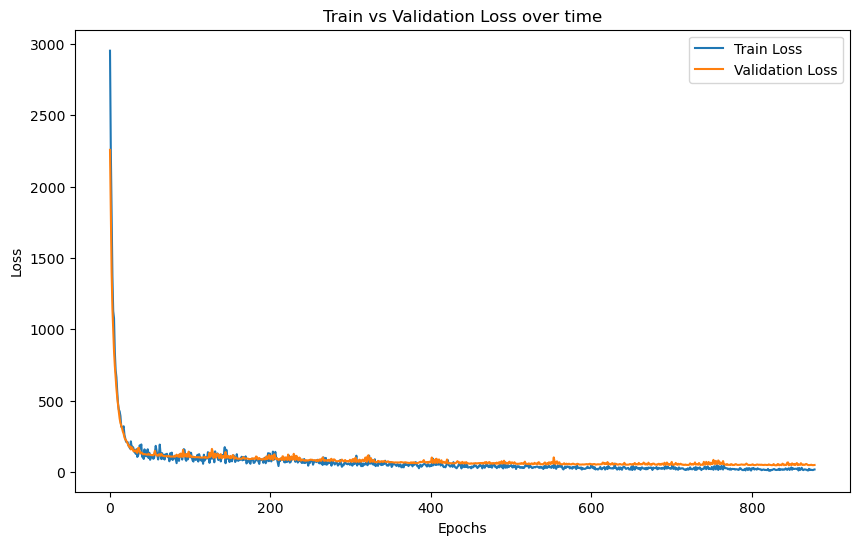

In [21]:
# Convert the history to a pandas dataframe
df_loss_history = pd.DataFrame(loss_history, columns=['train_loss', 'val_loss'])

# plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(df_loss_history['train_loss'], label='Train Loss')
plt.plot(df_loss_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over time')
plt.legend()
plt.show()


### Evaluation

In [22]:
test_true = test_lmrk
test_pred = model.predict(test_img)

print("Combine L2 And Cosine Error: ", combine_l2_cosine_loss(test_true, test_pred).numpy())

Combine L2 And Cosine Error:  47.869415


### visualize result

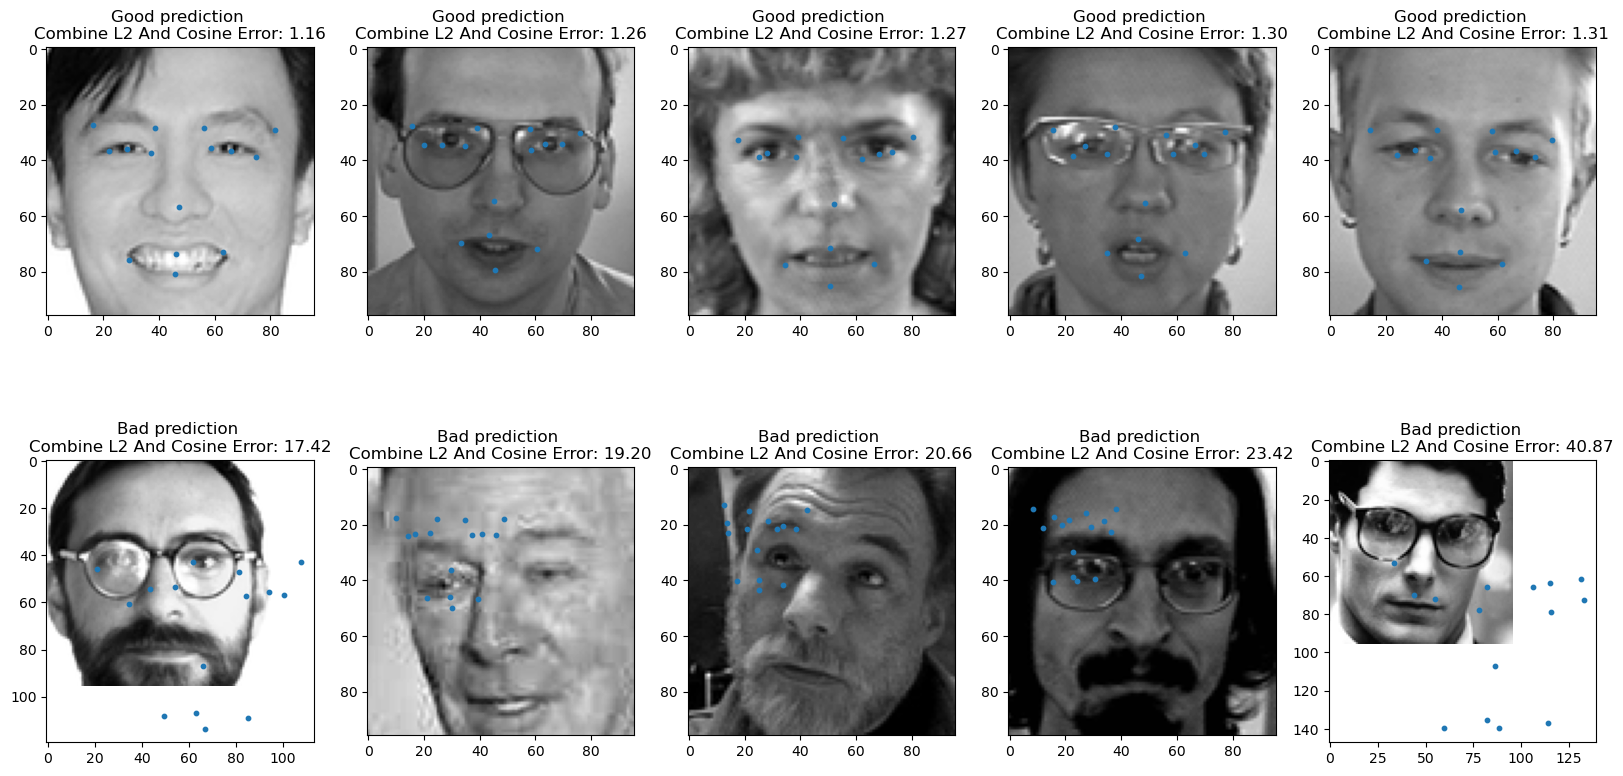

In [23]:
def plot_sample(image, landmarks, ax):
    ax.imshow(image, cmap='gray')
    landmarks = np.reshape(landmarks, (-1, 2)) # reshape to (15, 2)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='o', s=10)

# suppose we have some predictions and ground truth data
predictions = model.predict(test_img)
ground_truth = test_lmrk  # assume this exists

errors = np.mean(np.abs(predictions - ground_truth), axis=1)
sorted_indices = np.argsort(errors)

# Indices of good predictions
good_indices = sorted_indices[:5]  

# Indices of bad predictions
bad_indices = sorted_indices[-5:]  

fig = plt.figure(figsize=(20,10))
for i in range(5):
    # Good predictions
    ax = fig.add_subplot(2, 5, i+1)
    plot_sample(test_img[good_indices[i]], predictions[good_indices[i]], ax)
    ax.set_title("Good prediction \nCombine L2 And Cosine Error: {:.2f}".format(errors[good_indices[i]]))

    # Bad predictions
    ax = fig.add_subplot(2, 5, i+6)
    plot_sample(test_img[bad_indices[i]], predictions[bad_indices[i]], ax)
    ax.set_title("Bad prediction \nCombine L2 And Cosine Error: {:.2f}".format(errors[bad_indices[i]]))

plt.show()
